In [2]:
import requests as r
import pandas as pd
import datetime as dt
import io
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import files, drive

## Setting up folder

Login to Google Drive and set `basepath` as the home folder where all files will be stored.

In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
basepath = '/content/drive/My Drive/PurpleAir/'

In [3]:
sensors_us = pd.read_csv('sensors_us.csv')

In [11]:
sensors_us.shape

(25944, 35)

Source: https://github.com/bomeara/purpleairpy/blob/master/api.md

In [4]:
field_names = {'field1': 'PM1.0_ATM', 'field2': 'PM2.5_ATM', 'field3': 'PM10.0_ATM', 'field4': 'Uptime_min', 'field5': 'RSSI (WiFi Signal Strength)', 'field6': 'Temperature_F', 'field7': 'Humidity_%', 'field8': 'PM2.5'}

## Select sensors

Select sensors to download data for based on city, state, specific label names or zipcode. Simply uncomment the selection criteria

In [5]:
city = 'Austin'
#state = 'TX'
#label_names = ['Columbia South', 'Columbia South B', 'Columbia University SEAS', 'Columbia University SEAS B']
#zipcode = 77840

Modify parameters below to select date range and averaging

In [6]:
start_date = '2019-10-01%2000:00:00' # Beginning of Oct 2019
end_date =  dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S') # time now
averaging = '60' # minutes 60 minutes = hourly average, 1440 mins = daily average

In [7]:
sensor_meta = ['ID', 'Label', 'Lat', 'Lon', 'ParentID', 'THINGSPEAK_PRIMARY_ID', 'THINGSPEAK_PRIMARY_ID_READ_KEY', 'THINGSPEAK_SECONDARY_ID', 'THINGSPEAK_SECONDARY_ID_READ_KEY', 'humidity', 'pressure', 'temp_f', 'street_address', 'city', 'state', 'zipcode']

Uncomment below based on selection criteria

In [0]:
#sensors_state = sensors_us.loc[sensors_us['state'] == state, sensor_meta].reset_index(drop=True)
#sensors_state.head()

In [8]:
sensors_city = sensors_us.loc[sensors_us['city'] == city, sensor_meta].reset_index(drop=True)
sensors_city.head()

,ID,Label,Lat,Lon,ParentID,THINGSPEAK_PRIMARY_ID,THINGSPEAK_PRIMARY_ID_READ_KEY,THINGSPEAK_SECONDARY_ID,THINGSPEAK_SECONDARY_ID_READ_KEY,humidity,pressure,temp_f,street_address,city,state,zipcode
0,26125,Circle-c-west,30.181337,-97.899920,NaN,695613,LWSC2BXC0TW9L98H,695614,R6WFE5WV8AZGA36I,25.0,996.67,73.0,Escarpment Blvd,Austin,TX,78739.0
1,26126,Circle-c-west B,30.181337,-97.899920,26125.0,695615,LYXYB8CL0GN0DN92,695616,C6CBCRYD0C1SHRCA,25.0,996.72,73.0,Escarpment Blvd,Austin,TX,78739.0
2,29003,circle-c-west-indoor,30.185177,-97.897041,NaN,731056,A78JCSVBCX88530D,731057,HQYV828Z6464N6BZ,39.0,990.30,79.0,6409 Aden Ln,Austin,TX,78739.0
3,29004,circle-c-west-indoor B,30.185177,-97.897041,29003.0,731058,L6YUEFV6GUE4C5G1,731059,AP1NUA2S504DAJ5V,NaN,NaN,NaN,6409 Aden Ln,Austin,TX,78739.0
4,2796,Lost Creek,30.276700,-97.837200,NaN,317108,SAQP68QUIQD4FON7,317109,NMMEBNP1J9MC13LN,52.0,995.21,93.0,2103 Kemper Cove,Austin,TX,78746.0


In [13]:
sensors_city.shape

(10, 16)

In [14]:
#sensors_zip = sensors_us.loc[(sensors_us['zipcode'] < zipcode+200) & (sensors_us['zipcode'] > zipcode-200), sensor_meta].reset_index(drop=True)
#sensors_zip.head()

In [15]:
ID_names = sensors_us[sensors_us['city'] == city.title()].ID.reset_index(drop=True)

In [16]:
#ID_names = sensors_us[sensors_us['state'] == state.title()].ID.reset_index(drop=True)

In [17]:
def get_hist_data(sensor_ID):
    sensor = sensors_us[sensors_us.ID == sensor_ID]
    sensor_name = sensor.Label.values[0].replace(' ', '_')
    
    channel_id = sensor['THINGSPEAK_PRIMARY_ID'].values[0]
    api_key = sensor['THINGSPEAK_PRIMARY_ID_READ_KEY'].values[0]
       
    ts_url = f'https://api.thingspeak.com/channels/{channel_id}/feeds.csv?&api_key={api_key}&start={start_date}&end={end_date}&average={averaging}'
    ts_data = r.get(ts_url)
    
    if not ts_data.ok:
        print(ts_data.reason)
    else:
        sensor_data = pd.read_csv(io.StringIO(ts_data.text))
        if sensor_name[-2:] == '_B':
            field_names = {'field8': f'PM2.5_{sensor_ID}'}
            req_cols = ['created_at', f'PM2.5_{sensor_ID}']
        else:
            field_names = {'field6': f'Temperature_F_{sensor_ID}', 'field7': f'Humidity_%_{sensor_ID}', 'field8': f'PM2.5_{sensor_ID}'}
            req_cols = ['created_at', f'Temperature_F_{sensor_ID}', f'Humidity_%_{sensor_ID}', f'PM2.5_{sensor_ID}']
        sensor_data.rename(mapper = field_names, axis = 'columns', inplace = True)
        return sensor_data[req_cols]

In [18]:
def get_multiple_sensors(ID_names):
    n = len(ID_names)
    sensors_df = get_hist_data(ID_names[0])
    print(sensors_df.head())
    for i in range(1,n):
        temp_df = get_hist_data(ID_names[i])
        sensors_df = sensors_df.merge(temp_df, how = 'outer', on = 'created_at', sort = True)
    
    sensors_df['Temperature_F_avg'] = sensors_df.filter(regex = 'Temperature.*').mean(axis = 1)
    sensors_df['Humidity_avg'] = sensors_df.filter(regex = 'Humidity.*').mean(axis = 1)
    return sensors_df

In [19]:
ID_names

0    26125
1    26126
2    29003
3    29004
4     2796
5     2797
6    34435
7    34436
8    22651
9    22652
Name: ID, dtype: int64

In [20]:
sensors_df = get_multiple_sensors(ID_names)

Empty DataFrame
Columns: [created_at, Temperature_F_26125, Humidity_%_26125, PM2.5_26125]
Index: []


In [21]:
sensors_df.head()

,Temperature_F_26125,Humidity_%_26125,PM2.5_26125,PM2.5_26126,created_at,Temperature_F_29003,Humidity_%_29003,PM2.5_29003,PM2.5_29004,Temperature_F_2796,...,Temperature_F_34435,Humidity_%_34435,PM2.5_34435,PM2.5_34436,Temperature_F_22651,Humidity_%_22651,PM2.5_22651,PM2.5_22652,Temperature_F_avg,Humidity_avg
0,NaN,NaN,NaN,NaN,2020-09-21 08:00:00 UTC,79.888889,39.814815,3.081111,3.108519,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.888889,39.814815
1,NaN,NaN,NaN,NaN,2020-09-21 09:00:00 UTC,79.433333,37.900000,3.453333,3.408333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.433333,37.900000
2,NaN,NaN,NaN,NaN,2020-09-21 10:00:00 UTC,79.066667,39.533333,3.588333,3.500667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.066667,39.533333
3,NaN,NaN,NaN,NaN,2020-09-21 11:00:00 UTC,79.966667,39.066667,2.805333,2.863000,76.100000,...,76.75,63.666667,25.944583,24.133333,78.083333,64.041667,22.674583,22.917826,77.725000,57.456250
4,NaN,NaN,NaN,NaN,2020-09-21 12:00:00 UTC,79.400000,38.100000,3.468667,3.361667,74.633333,...,74.40,69.733333,26.296000,25.201333,77.000000,68.000000,23.019000,23.326667,76.358333,60.858333


In [22]:
sensors_df.shape

(271, 23)

In [23]:
city_f = city.replace(' ','-')
#state_f = state.replace(' ','-')
#zipcode_f = str(zipcode)

In [24]:
sensor_data_filename = f'{city_f}-{start_date[:10]}-to-{end_date[:10]}-{averaging}.csv'

In [25]:
# sensors_df.to_csv(sensor_data_filename, index = False)

NameError: name 'basepath' is not defined

<AxesSubplot:>

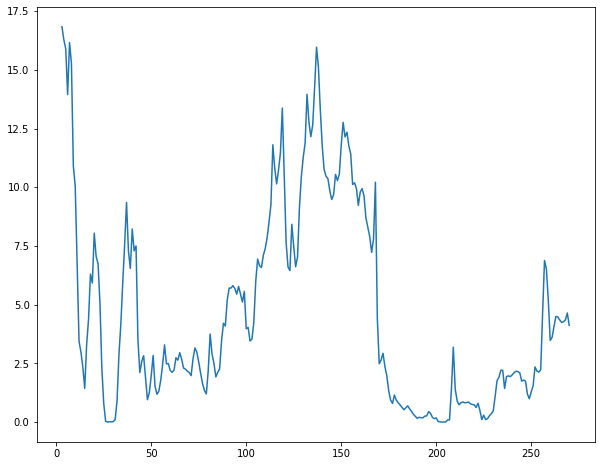

In [26]:
sensors_df.iloc[:,11].plot(figsize = [10,8])

In [28]:
sensors_df.shape

(271, 23)